In [0]:
import torch
import csv 
import os,sys 
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
bp = 4
no = 5
no2 = 6
nox = 7
out_rh = 8
out_t = 9
pm25t = 10
uvpm = 14
with open('airquality17-20.csv', 'r') as csvfile:
    bp_col = []
    no_col = []
    no2_col = []
    nox_col = []
    out_rh_col = []
    out_t_col = []
    pm25t_col = []
    uvpm_col = []
    for line in csvfile.readlines():
        array = line.split(',')
        array = ['0' if len(x)<1 else x for x in array]
        bp_col.append(array[bp])
        no_col.append(array[no])
        no2_col.append(array[no2])
        nox_col.append(array[nox])
        out_rh_col.append(array[out_rh])
        out_t_col.append(array[out_t])
        pm25t_col.append(array[pm25t])
        uvpm_col.append(array[uvpm].rstrip("\n"))

del bp_col[0]
del no_col[0]
del no2_col[0]
del nox_col[0]
del out_rh_col[0]
del out_t_col[0]
del pm25t_col[0]
del uvpm_col[0]
uvpm_col[366] = '0'
uvpm_col[367] = '0'

bp_col = list(map(float,bp_col))
no_col = list(map(float,no_col))
no2_col = list(map(float, no2_col))
nox_col = list(map(float, nox_col))
out_rh_col = list(map(float, out_rh_col))
out_t_col = list(map(float, out_t_col))
pm25t_col = list(map(float, pm25t_col))
uvpm_col = list(map(float, uvpm_col))

In [0]:
data = [[bp, no, nox, out_rh, out_t, pm25t, uvpm] for bp, no,nox,out_rh, out_t,pm25t, uvpm in zip(bp_col, no_col, nox_col, out_rh_col, out_t_col, pm25t_col, uvpm_col)]

In [0]:
normalized = MinMaxScaler(feature_range=(-10,10))
data = normalized.fit_transform(data)
no2_col = np.asarray(no2_col)
no2_col = normalized.fit_transform(no2_col.reshape(-1,1))

In [0]:
data_test_len = int(len(data)*0.10)
data_train_len = len(data) - data_test_len
data_train = data[:data_train_len]
data_test = data[data_train_len:]
target_train = no2_col[:data_train_len-data_test_len]
target_val = no2_col[data_train_len-data_test_len:data_train_len]
target_test = no2_col[data_train_len:]
data_train = data[:data_train_len-data_test_len]
data_val = data[data_train_len - data_test_len:data_train_len]

In [0]:
class Dataset(Dataset):
    def __init__(self, feature, target):
        self.feature = torch.FloatTensor(feature)     
        self.target = torch.FloatTensor(target) 
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
        x = self.feature[index]
        y = self.target[index]
        return x,y

In [0]:
train_dataset = Dataset(data_train, target_train)
val_dataset = Dataset(data_val, target_val)
test_dataset = Dataset(data_test, target_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size = 32, shuffle = True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 32, shuffle = False)

In [0]:
class simple_model(nn.Module):
    def __init__(self,in_feat,out_feat):
        super(simple_model, self).__init__()
        self.first_layer = nn.Linear(in_feat,300)
        self.activation1 = nn.ReLU()
        self.second_layer =nn.Linear(300,300)
        #self.dropout = nn.Dropout(0.2)
        self.activation2 = nn.ReLU()
        self.third_layer = nn.Linear(300,300)
        self.activation3 = nn.ReLU()
        self.fourth_layer = nn.Linear(300,1)

    def forward(self,x):
        out = self.first_layer(x)
        out = self.activation1(out)
        out = self.second_layer(out)
        #out = self.dropout(out)
        out = self.activation2(out)
        out = self.third_layer(out)
        out = self.activation3(out)
        out = self.fourth_layer(out)

        return out

In [0]:
model = simple_model(7,1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-6)
model.to(device)

simple_model(
  (first_layer): Linear(in_features=7, out_features=300, bias=True)
  (activation1): ReLU()
  (second_layer): Linear(in_features=300, out_features=300, bias=True)
  (activation2): ReLU()
  (third_layer): Linear(in_features=300, out_features=300, bias=True)
  (activation3): ReLU()
  (fourth_layer): Linear(in_features=300, out_features=1, bias=True)
)

In [0]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = []
    start_time = time.time()
    for index, (feature,target) in enumerate(train_loader):
        optimizer.zero_grad()
        feature = feature.to(device)
        target = target.view(-1,1)
        target = target.to(device)
        out = model(feature)
        loss = criterion(out,target)
        var_target = target.var(dim=0)
        var_target = var_target.to("cpu")
        var_target = var_target.numpy()
        loss_item = loss.item()/var_target
        train_loss.append(loss_item)

        loss.backward()
        optimizer.step()
    end_time = time.time()
    avg_loss = np.mean(train_loss)
    print('Training Loss:', avg_loss, 'Time: ',end_time-start_time)
    return avg_loss

In [0]:
def test_model(model, test_loader, criterion, optimizer):   
    with torch.no_grad():
        model.eval()
        val_loss = []
        total_predictions = 0
        total_correct = 0
        for index, (feature,target) in enumerate(test_loader):
            feature = feature.to(device)
            
            target = target.view(-1,1)
            target = target.to(device)
       
            out = model(feature)

            total_predictions += target.size(0)
            #out = (out * (10**2)).round()/(10**2)
            #target = (target * (10**2)).round()/(10**2)
            total_correct += (out.round()== target.round()).sum().item()

            loss = criterion(out, target).detach()
            var_target = target.var(dim=0)
            var_target = var_target.to("cpu")
            var_target = var_target.numpy()
            loss_item = loss.item()/var_target
    
            val_loss.append(loss_item)

        avg_loss = np.mean(val_loss)
        acc = (total_correct/total_predictions)*100
        print('Testing(Val) Loss: ', avg_loss)
        print('Testing(Val) Accuracy: ', acc, '%')
        return avg_loss, acc

In [0]:
num_epoch = 200
train_loss_list = []
val_loss_list = []
val_acc_list = []
for i in range(num_epoch):
    print("Starting Epoch: ", i)
    train_loss = train_model(model, train_dataloader, criterion, optimizer)
    val_loss, val_acc = test_model(model, val_dataloader, criterion, optimizer)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print('='*25)    

Starting Epoch:  0
Training Loss: 1.7454178 Time:  0.09001684188842773
Testing(Val) Loss:  0.62389356
Testing(Val) Accuracy:  31.41025641025641 %
Starting Epoch:  1
Training Loss: 0.81927013 Time:  0.06381487846374512
Testing(Val) Loss:  2.0673203
Testing(Val) Accuracy:  8.974358974358974 %
Starting Epoch:  2
Training Loss: 0.5220224 Time:  0.06236743927001953
Testing(Val) Loss:  0.45745787
Testing(Val) Accuracy:  33.97435897435898 %
Starting Epoch:  3
Training Loss: 0.46290597 Time:  0.06409382820129395
Testing(Val) Loss:  0.53558743
Testing(Val) Accuracy:  44.871794871794876 %
Starting Epoch:  4
Training Loss: 1.0706987 Time:  0.060903072357177734
Testing(Val) Loss:  1.6453726
Testing(Val) Accuracy:  12.82051282051282 %
Starting Epoch:  5
Training Loss: 0.69869936 Time:  0.06730532646179199
Testing(Val) Loss:  1.3446242
Testing(Val) Accuracy:  15.384615384615385 %
Starting Epoch:  6
Training Loss: 0.50854933 Time:  0.05672645568847656
Testing(Val) Loss:  0.8235055
Testing(Val) Accura

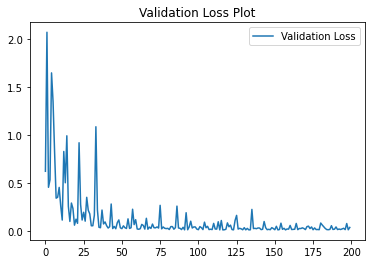

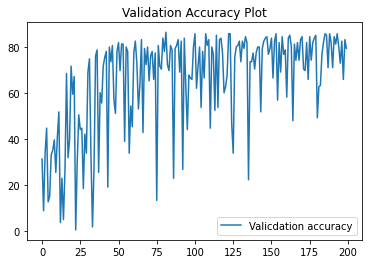

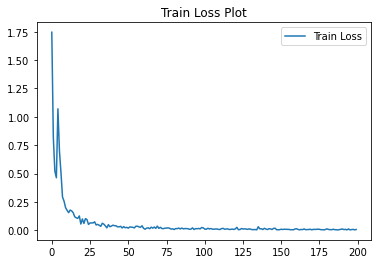

In [0]:
plt.title("Validation Loss Plot")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.show()

plt.title("Validation Accuracy Plot")
plt.plot(val_acc_list, label="Valicdation accuracy")
plt.legend()
plt.show()

plt.title("Train Loss Plot")
plt.plot(train_loss_list, label = "Train Loss")
plt.legend()
plt.show()

In [0]:
def test_model_out(model, test_loader, criterion, optimizer):   
    with torch.no_grad():
        model.eval()
        out_list = []
        target_list = []
        loss_list = []
        for index, (feature,target) in enumerate(test_loader):
            feature = feature.to(device)
            target = target.to(device)
            out = model(feature)
            loss = criterion(out, target).detach()
            out = out.view(-1)
            out = out.to("cpu")
            out = out.numpy()
            out_list.extend(out)
            var_target = target.var(dim=0)
            var_target = var_target.to("cpu")
            var_target = var_target.numpy()
            loss_item = loss.item()/var_target
            loss_list.append(loss_item)
            target = target.to("cpu")
            target = target.view(-1)
            target = target.numpy()
            target_list.extend(target)
        return out_list, target_list, np.mean(loss_list)

In [0]:
out_list, target_list, test_loss = test_model_out(model,test_dataloader, criterion, optimizer)
print(test_loss)

0.007062328


In [0]:
plt.title("Test Predictions Vs. Test Targets")
plt.plot(out_list,target_list)
plt.autoscale(axis='x')
plt.show()

In [0]:
x = np.arange(0,len(out_list),1)
plt.title("Scatter Plot of Test Targets and Predictions")
plt.scatter(x,out_list, label ="Test Predictions")
plt.scatter(x,target_list, label ="Test Targets" )
plt.grid(True)
plt.legend()
plt.show()

In [0]:
print(len(out_list))

In [0]:
x = np.arange(0,len(out_list),1)

In [0]:
print(len(x))